In [120]:
import pandas as pd
import psycopg2
from sqlalchemy import create_engine, delete, Table, MetaData
import seaborn as sns 
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import rcParams
from matplotlib import font_manager
from matplotlib.ticker import MultipleLocator
matplotlib.rcdefaults()

In [2]:
DB_PARAMS = {
    'dbname': 'postgres',   # Replace with your database name
    'user': 'postgres',         # Replace with your PostgreSQL user
    'password': 'meomeo', # Replace with your PostgreSQL password
    'host': 'localhost',         # PostgreSQL server host
    'port': '5432'               # Default port for PostgreSQL
}

In [3]:
def read_sql(query):
# Read SQL to DataFrame
        conn = psycopg2.connect(**DB_PARAMS)
        df = pd.read_sql_query(query, conn)
        conn.close()
        return df

In [16]:
accu_path =  "/Users/tpminh/Downloads/Roboto,Roboto_Mono/Roboto/static/Roboto-Regular.ttf"
font_manager.fontManager.addfont(accu_path)

## **We can start looking at number of address and its balance overtime**

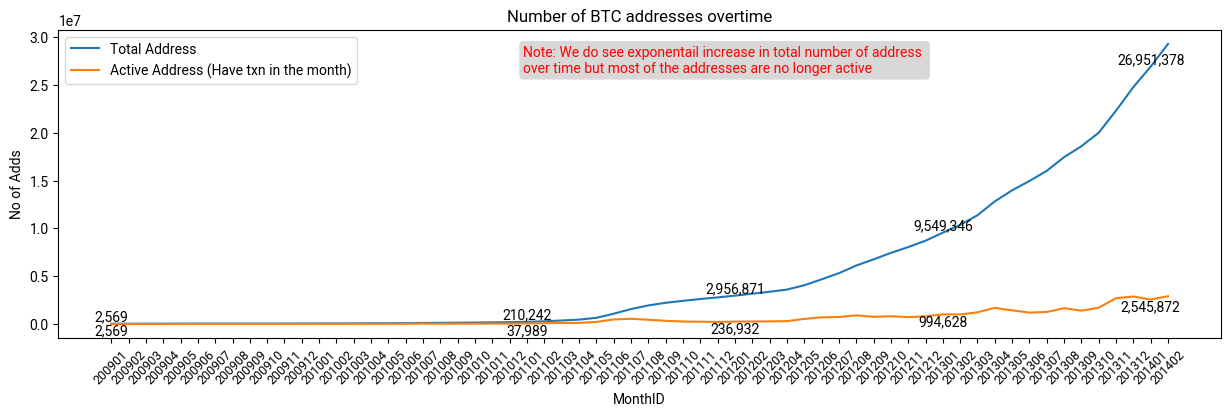

In [67]:
#df = read_sql('select count(*) total_address, count(case when count_outflow_cm + count_inflow_cm > 0 then addresses end ) active_address , month_id::text from fact_address_snapshot_monthly group by month_id order by month_id')
matplotlib.rcParams['font.family'] = 'Roboto' 
plt.figure(figsize=(15, 4))
ax = sns.lineplot(data = df, x = 'month_id', y = 'total_address', label='Total Address' )
ax2 = sns.lineplot(data = df, x = 'month_id', y = 'active_address',label='Active Address (Have txn in the month)'  )
plt.xticks(rotation=45, fontsize=9)
plt.title('Number of BTC addresses overtime')
plt.xlabel('MonthID')
plt.ylabel('No of Adds')
for i, row in df[df['month_id'].isin(['200901', '201101','201201','201301','201401']) ].iterrows():
    ax.text(x=row['month_id'], y=row['total_address'], s=f'{row["total_address"]:,}', color='black', ha='center', va='bottom')
for i, row in df[df['month_id'].isin(['200901', '201101','201201','201301','201401']) ].iterrows():
    ax2.text(x=row['month_id'], y=row['active_address'], s=f'{row["active_address"]:,}', color='black', ha='center', va='top')
plt.legend(loc='upper left')

text = ("Note: We do see exponentail increase in total number of address \n"
        "over time but most of the addresses are no longer active")

plt.text(0.4, 0.95, text, fontsize= 10, color='red'
            ,transform = plt.gca().transAxes
            ,bbox=dict(facecolor='grey', alpha=0.3, boxstyle='round',edgecolor='none')
            ,ha='left', va='top'
            )
        
plt.show()

/var/folders/np/yjbf57612_30_mjbr_d794yh0000gn/T/ipykernel_70541/352506468.py:4: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, conn)


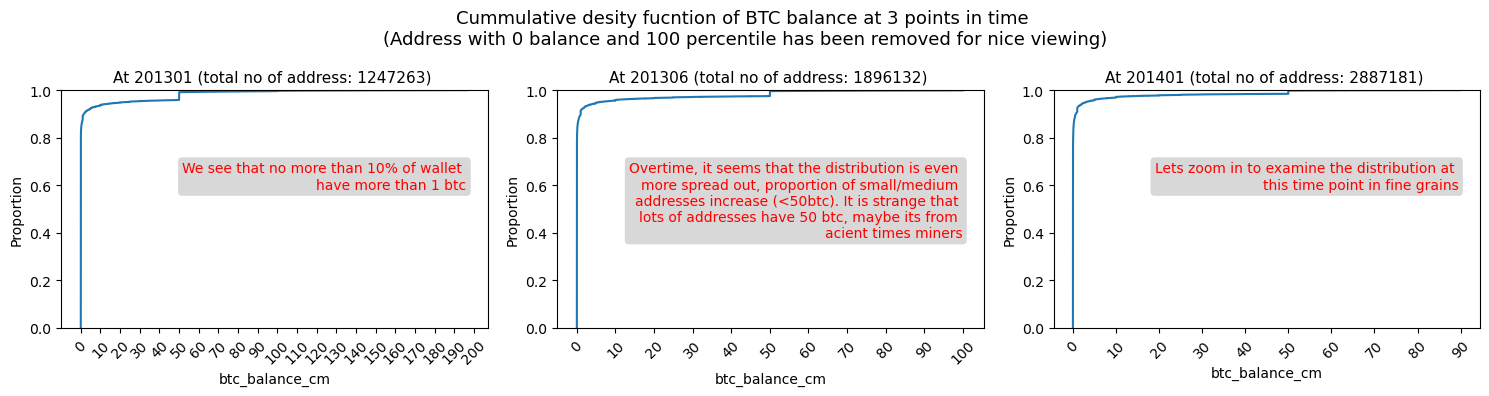

In [221]:
df_add = read_sql( 'select month_id,btc_balance_cm,percentile_rank from minhtp_test_percentile where percentile_rank <=0.99' )
fig, axes = plt.subplots(1,3,figsize = (15,4) )
axes = axes.flatten()
for ax, month in zip(axes,[201301,201306,201401]):
    sns.ecdfplot(df_add[df_add['month_id'] == month ], x = 'btc_balance_cm', ax = ax)
    ax.xaxis.set_major_locator(MultipleLocator(10))
    no_add =len(df_add[df_add['month_id'] == month])
    ax.set_title(f'At {month} (total no of address: {no_add}) ', fontsize = 11)
    ax.tick_params(axis='x', rotation=45) 
plt.suptitle('Cummulative desity fucntion of BTC balance at 3 points in time \n'
             '(Address with 0 balance and 100 percentile has been removed for nice viewing)'
             , fontsize = 13)

axes[0].text(0.95,0.7,'We see that no more than 10% of wallet \n' 
                        'have more than 1 btc'
            ,transform=axes[0].transAxes
            ,bbox=dict(facecolor='grey', alpha=0.3, boxstyle='round',edgecolor='none')
            ,color = 'red'
            ,ha='right', va='top'
            )

axes[1].text(0.95,0.7,'Overtime, it seems that the distribution is even \n'
                       'more spread out, proportion of small/medium \n' 
                        'addresses increase (<50btc). It is strange that \n' 
                        'lots of addresses have 50 btc, maybe its from \n' 
                         'acient times miners' 
            ,transform=axes[1].transAxes
            ,bbox=dict(facecolor='grey', alpha=0.3, boxstyle='round',edgecolor='none')
            ,color = 'red'
            ,ha='right', va='top'
            )

axes[2].text(0.95,0.7,'Lets zoom in to examine the distribution at \n' 
                         'this time point in fine grains' 
            ,transform=axes[2].transAxes
            ,bbox=dict(facecolor='grey', alpha=0.3, boxstyle='round',edgecolor='none')
            ,color = 'red'
            ,ha='right', va='top'
            )

plt.tight_layout()
plt.show()

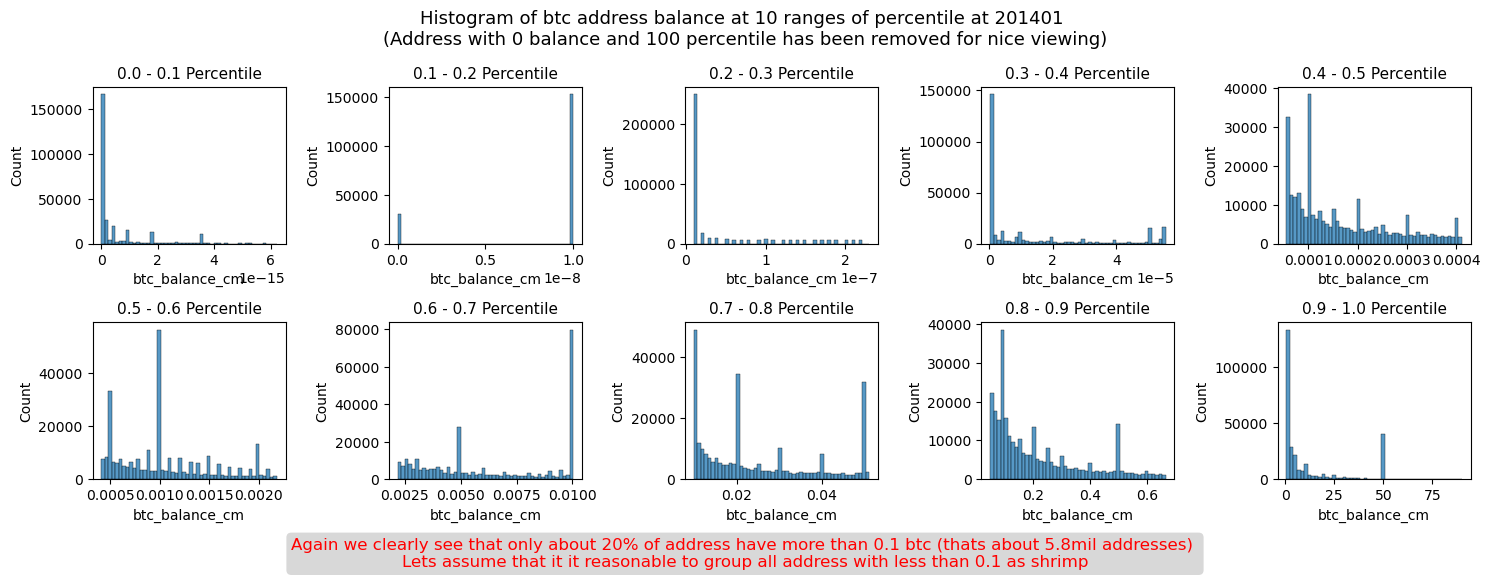

In [222]:
#percentile_range =  [(i/10,(i+2)/10) for i in range(0,10,2) ]
percentile_range =  [(i/10,(i+1)/10) for i in range(0,10,1) ]
fig,axes = plt.subplots(2,5, figsize = (15,6))
axes = axes.flatten()
for ax, (lower,upper)  in zip (axes , percentile_range):
    data_filtered = df_add[(df_add['month_id'] == 201401) & (df_add['percentile_rank'] >= lower ) & (df_add['percentile_rank'] < upper)]
    sns.histplot(data_filtered, x = 'btc_balance_cm', ax =ax, bins = 50 )
    ax.set_title(f'{lower:.1f} - {upper:.1f} Percentile' , fontsize = 11 )    
plt.subplots_adjust(bottom=0.1) 
comment = ('Again we clearly see that only about 20% of address have more than 0.1 btc (thats about 5.8mil addresses) \n'
                      'Lets assume that it it reasonable to group all address with less than 0.1 as shrimp')
fig.text(0.5, 0.1,comment,bbox=dict(facecolor='grey', alpha=0.3, boxstyle='round',edgecolor='none')
            ,color = 'red', va = 'top', ha = 'center', fontsize = 12)
plt.suptitle('Histogram of btc address balance at 10 ranges of percentile at 201401 \n'
             '(Address with 0 balance and 100 percentile has been removed for nice viewing)'
            ,fontsize = 13)

plt.tight_layout(rect=[0, 0.1, 1, 1])
plt.show()

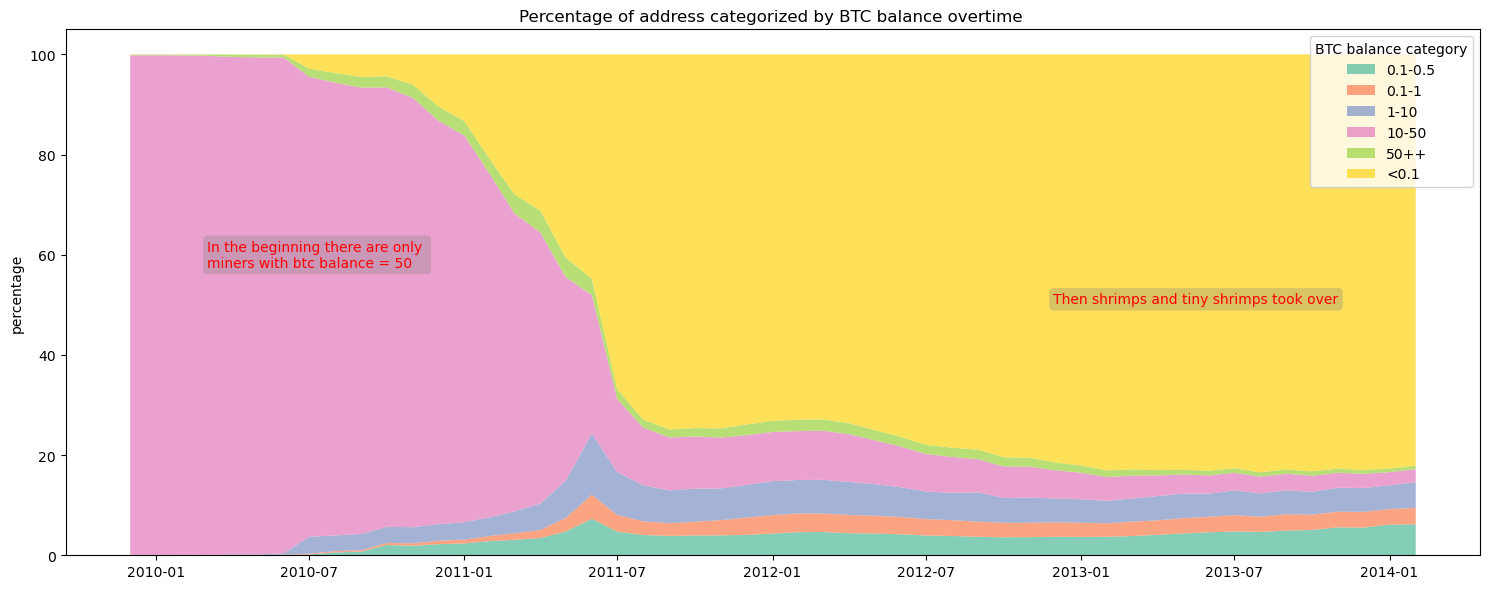

In [223]:
#df_btc_cate = read_sql("""select balance_cate,to_date(month_id::text ,'YYYYMM') timeid  ,count_add from test_btc_balance_cate""" )
#df_btc_cate_gb = df_btc_cate.groupby(['timeid','balance_cate']).sum().reset_index()
#df_btc_cate_gb_pv = df_btc_cate_gb.pivot(index="timeid", columns="balance_cate", values="count_add")
#df_btc_cate_gb_pv =  df_btc_cate_gb_pv.div(df_btc_cate_gb_pv.sum(axis=1), axis=0) * 100

plt.figure(figsize=(15, 6))
plt.stackplot(
    df_btc_cate_gb_pv.index,
    df_btc_cate_gb_pv.T,
    labels=df_btc_cate_gb_pv.columns,
    colors=sns.color_palette("Set2", len(df_btc_cate['balance_cate'].unique())),
    alpha=0.8,
)

plt.text(0.1,0.6,('In the beginning there are only \n' 
                    'miners with btc balance = 50')
            ,transform = plt.gca().transAxes
            ,bbox=dict(facecolor='grey', alpha=0.3, boxstyle='round',edgecolor='none')
            ,color = 'red'
            ,ha='left', va='top'
            )

plt.text(0.9,0.5,('Then shrimps and tiny shrimps took over')
            ,transform = plt.gca().transAxes
            ,bbox=dict(facecolor='grey', alpha=0.3, boxstyle='round',edgecolor='none')
            ,color = 'red'
            ,ha='right', va='top'
            )


plt.legend(title = 'BTC balance category', loc = 'upper right')
plt.title('Percentage of address categorized by BTC balance overtime ')
plt.ylabel('percentage')
plt.tight_layout()
plt.show()



## **Now lets have a look at miner balance**

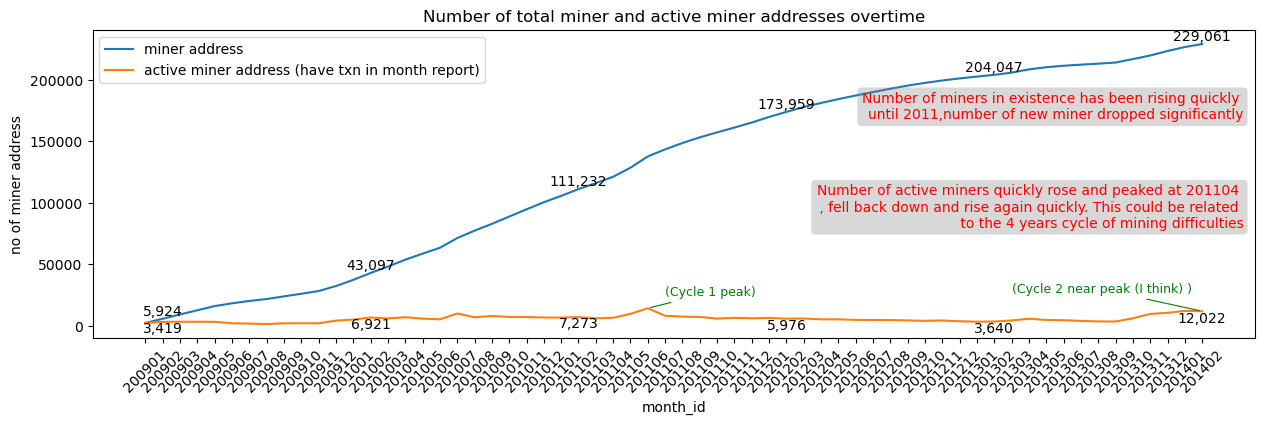

In [224]:
#df_miner = read_sql('select count(case when miner_flag = 1 then addresses end) miner_address, count(case when count_outflow_cm + count_inflow_cm > 0 and miner_flag = 1 then addresses end ) active_miner_address , month_id::text from fact_address_snapshot_monthly group by month_id order by month_id')

plt.figure(figsize = (15,4))
ax = sns.lineplot(data =  df_miner , x = 'month_id', y ='miner_address' , label = 'miner address')
ax1 = sns.lineplot(data =  df_miner , x = 'month_id', y ='active_miner_address'  , label = 'active miner address (have txn in month report)' )

for i, row in df_miner[df_miner['month_id'].isin(['200902','201002','201102','201202','201302','201402' ]) ].iterrows():
    ax.text(x = row['month_id'] , y = row['miner_address'],  s= f'{row["miner_address"]:,}' , ha = 'center', va = 'bottom', color = 'black' )
    ax1.text(x = row['month_id'] , y = row['active_miner_address'],  s= f'{row["active_miner_address"]:,}' , ha = 'center', va = 'top', color = 'black' )


plt.text(0.99,0.8,('Number of miners in existence has been rising quickly \n' 
                   'until 2011,number of new miner dropped significantly' )
                    ,ha = 'right', va = 'top'
                    ,transform = plt.gca().transAxes
                    ,bbox=dict(facecolor='grey', alpha=0.3, boxstyle='round',edgecolor='none')
                     , color = 'red' , fontsize = 10
        )

plt.text(0.99,0.5,('Number of active miners quickly rose and peaked at 201104 \n '
                    ', fell back down and rise again quickly. This could be related \n '
                   'to the 4 years cycle of mining difficulties'  )
                    ,ha = 'right', va = 'top'
                    ,transform = plt.gca().transAxes
                    ,bbox=dict(facecolor='grey', alpha=0.3, boxstyle='round',edgecolor='none')
                     , color = 'red' , fontsize = 10
        )
plt.annotate(
    f'(Cycle 1 peak)',  # Annotation text
    xy=(29, max(df_miner[df_miner['month_id'] == '201106']['active_miner_address']) ), # Point to annotate
    xytext=(29 + 1, max(df_miner[df_miner['month_id'] == '201106']['active_miner_address'])  + 10000),  # Text position
    arrowprops=dict(arrowstyle='-', color='green', lw=0.8),  # Minimal arrow
    fontsize=9,
    color='green'
)

        
plt.annotate(
    f'(Cycle 2 near peak (I think) )',  # Annotation text
    xy=(61, max(df_miner[df_miner['month_id'] == '201402']['active_miner_address']) ), # Point to annotate
    xytext=(50 , max(df_miner[df_miner['month_id'] == '201402']['active_miner_address'])  + 15000),  # Text position
    arrowprops=dict(arrowstyle='-', color='green', lw=0.8),  # Minimal arrow
    fontsize=9,
    color='green'
)



plt.ylabel('no of miner address')
plt.xticks(rotation =45)
plt.legend(loc = 'upper left')
plt.title('Number of total miner and active miner addresses overtime')
plt.show()



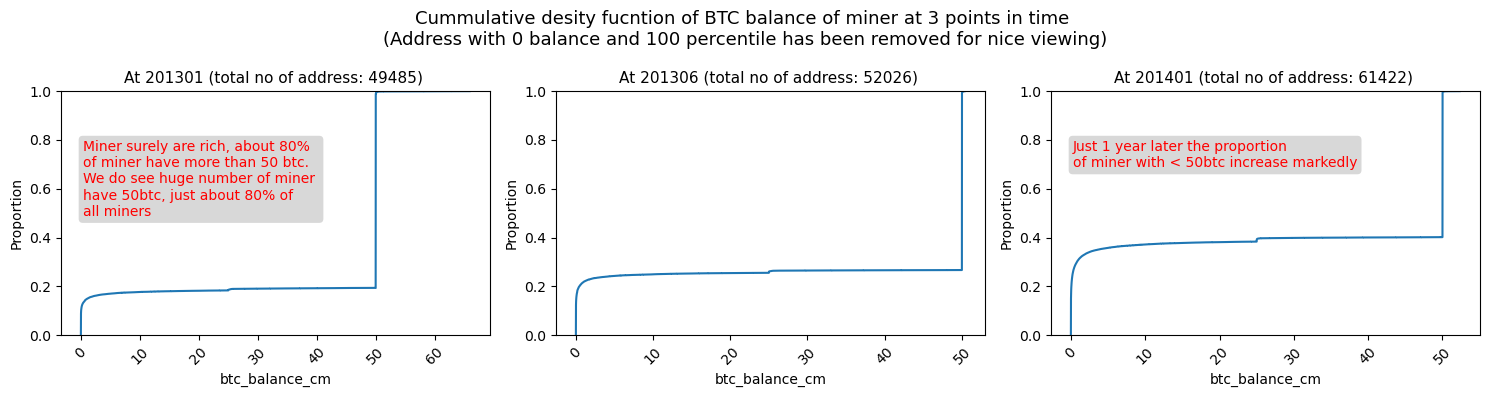

In [225]:
#df_miner_p = read_sql( 'select month_id,btc_balance_cm,percentile_rank from minhtp_test_percentile_miner where percentile_rank <=0.99' )
fig, axes = plt.subplots(1,3,figsize = (15,4) )
axes = axes.flatten()
for ax, month in zip(axes,[201301,201306,201401]):
    sns.ecdfplot(df_miner_p[df_miner_p['month_id'] == month ], x = 'btc_balance_cm', ax = ax)
    ax.xaxis.set_major_locator(MultipleLocator(10))
    no_add =len(df_miner_p[df_miner_p['month_id'] == month])
    ax.set_title(f'At {month} (total no of address: {no_add}) ', fontsize = 11)
    ax.tick_params(axis='x', rotation=45) 
plt.suptitle('Cummulative desity fucntion of BTC balance of miner at 3 points in time \n'
             '(Address with 0 balance and 100 percentile has been removed for nice viewing)'
             , fontsize = 13)

axes[0].text(0.05,0.8,('Miner surely are rich, about 80% \n' 
             'of miner have more than 50 btc.\n'  
             'We do see huge number of miner \n' 
             'have 50btc, just about 80% of \n' 
             'all miners')
            ,transform=axes[0].transAxes
            ,bbox=dict(facecolor='grey', alpha=0.3, boxstyle='round',edgecolor='none')
            ,color = 'red'
            ,ha='left', va='top'
            )

axes[2].text(0.05,0.8,('Just 1 year later the proportion \n'
                        'of miner with < 50btc increase markedly' )
            ,transform=axes[2].transAxes
            ,bbox=dict(facecolor='grey', alpha=0.3, boxstyle='round',edgecolor='none')
            ,color = 'red'
            ,ha='left', va='top'
            )


plt.tight_layout()
plt.show()



## **Now we analyse some attributes about btc transactions**

/var/folders/np/yjbf57612_30_mjbr_d794yh0000gn/T/ipykernel_70541/352506468.py:4: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, conn)


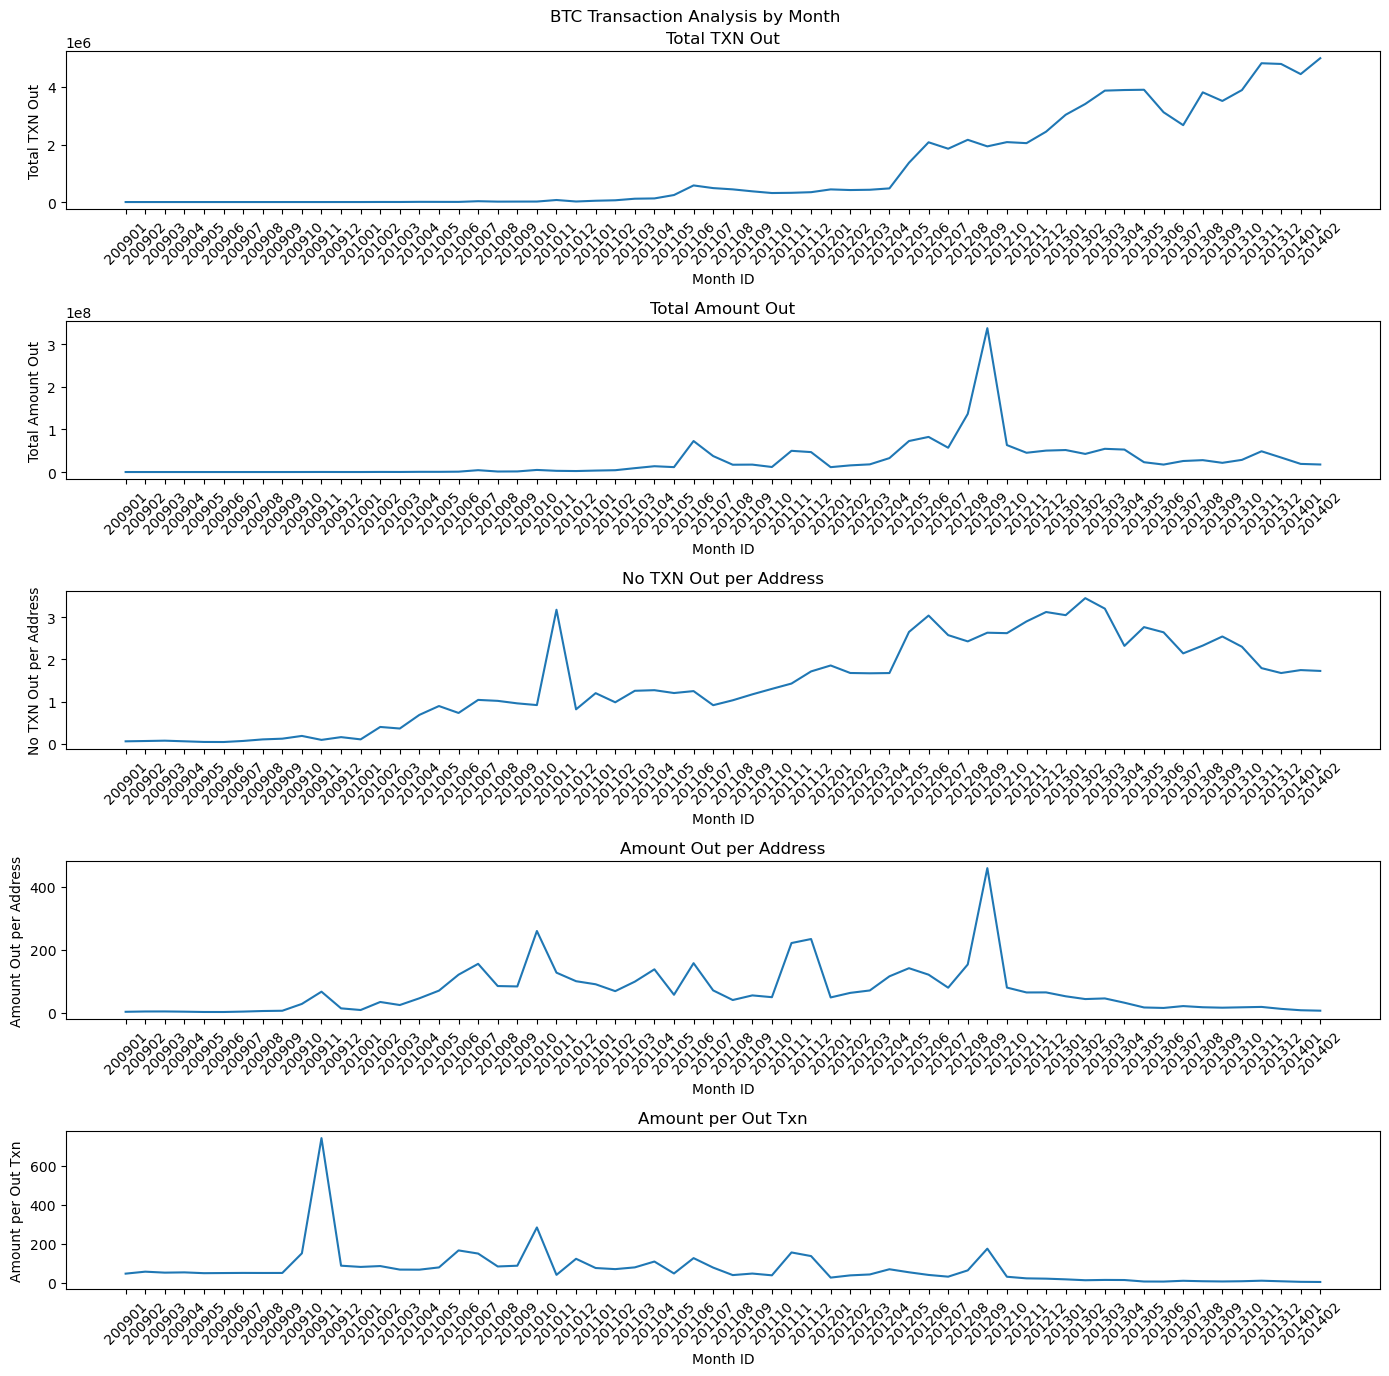

In [227]:
df = read_sql('''select 
sum(count_outflow_cm) total_txn_out
,sum(sum_outflow_cm) total_amt_out
,sum(sum_outflow_cm)/sum(count_outflow_cm) amt_per_txn
,sum(count_outflow_cm)/count(case when count_outflow_cm + count_inflow_cm > 0 then addresses end ) txn_out_per_add
,sum(sum_outflow_cm)/count(case when count_outflow_cm + count_inflow_cm > 0 then addresses end ) amt_out_per_add
,month_id::text 
from fact_address_snapshot_monthly
group by month_id 
 ''')

fig, axes = plt.subplots(5, 1, figsize=(14, 14))

axes = axes.flatten()

sns.lineplot(data=df, x='month_id', y='total_txn_out', ax=axes[0])
axes[0].set_title('Total TXN Out')
axes[0].set_xlabel('Month ID')
axes[0].set_ylabel('Total TXN Out')
axes[0].tick_params(axis='x', rotation=45)  # Rotate x-axis ticks

# Plot total_amt_out vs month_id
sns.lineplot(data=df, x='month_id', y='total_amt_out', ax=axes[1])
axes[1].set_title('Total Amount Out')
axes[1].set_xlabel('Month ID')
axes[1].set_ylabel('Total Amount Out')
axes[1].tick_params(axis='x', rotation=45)  # Rotate x-axis ticks

# Plot txn_out_per_add vs month_id
sns.lineplot(data=df, x='month_id', y='txn_out_per_add', ax=axes[2])
axes[2].set_title('No TXN Out per Address')
axes[2].set_xlabel('Month ID')
axes[2].set_ylabel('No TXN Out per Address')
axes[2].tick_params(axis='x', rotation=45)  # Rotate x-axis ticks

# Plot amt_out_per_add vs month_id
sns.lineplot(data=df, x='month_id', y='amt_out_per_add', ax=axes[3])
axes[3].set_title('Amount Out per Address')
axes[3].set_xlabel('Month ID')
axes[3].set_ylabel('Amount Out per Address')
axes[3].tick_params(axis='x', rotation=45)  # Rotate x-axis ticks

# Plot amt per txn vs month_id
sns.lineplot(data=df, x='month_id', y='amt_per_txn', ax=axes[4])
axes[4].set_title('Amount per Out Txn')
axes[4].set_xlabel('Month ID')
axes[4].set_ylabel('Amount per Out Txn')
axes[4].tick_params(axis='x', rotation=45)  # Rotate x-axis ticks

plt.suptitle('BTC Transaction Analysis by Month' , fontsize=12)

plt.tight_layout()

plt.subplots_adjust(top=0.95)


In [18]:
query =  """
with cte as (
select 
count(case when count_inflow_cm > 0 and month_onchain <> 0 then count_inflow_cm end) count_month_in
,count(case when count_outflow_cm > 0 and month_onchain <> 0 then count_outflow_cm end) count_month_out
,addresses
from fact_address_snapshot_monthly  where 
month_id between  201308 and 201401
group by addresses
)
select 
count(addresses ) count_add
,count_month_in
,count_month_out
from cte
group by 
count_month_in
,count_month_out
"""



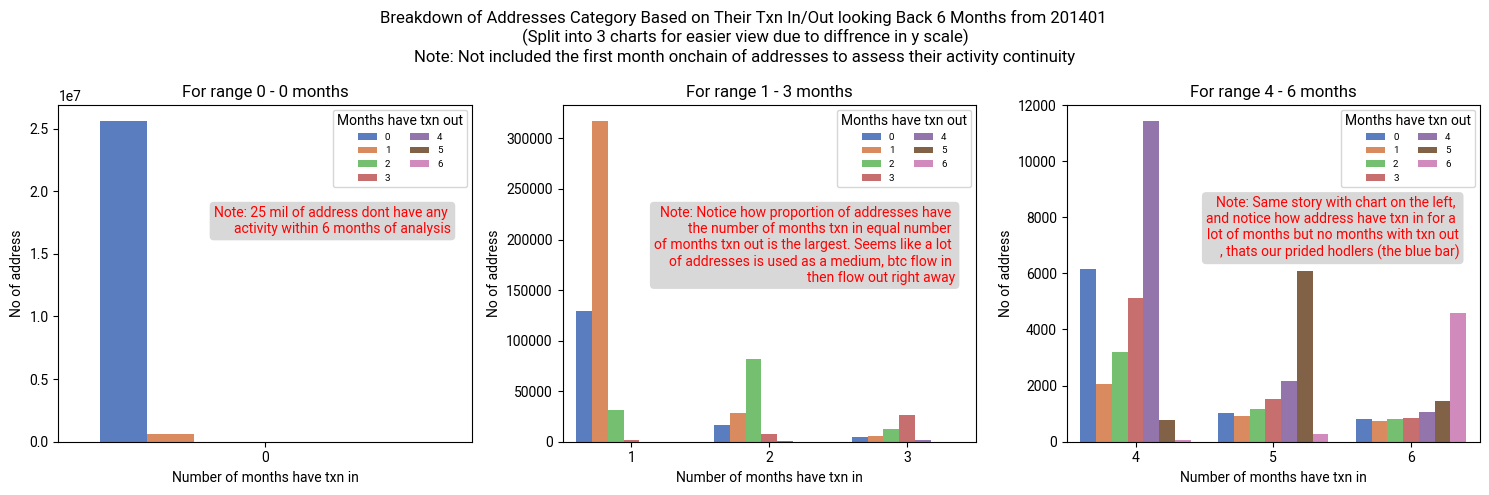

In [81]:
#df_inout_cate = read_sql(query)

fig, axes = plt.subplots(1,3, figsize= (15,5))
range_txn = [[0], [1,2,3], [4,5,6]]
axes = axes.flatten()
for ax,range_txn in zip(axes,range_txn) :
    sns.barplot(x = 'count_month_in' , y = 'count_add' , hue = 'count_month_out'
                , data = df_inout_cate[df_inout_cate['count_month_in'].isin(range_txn)] 
                , ax = ax, palette = 'muted'
                )
    ax.set_title(f'For range {min(range_txn)} - {max(range_txn)} months')
    ax.set_xlabel('Number of months have txn in')
    ax.set_ylabel('No of address')
    ax.legend(
    title='Months have txn out',
    loc='upper right',
    ncol=2,  # Arrange legend items in 2 columns
    fontsize=7
    )
plt.suptitle('Breakdown of Addresses Category Based on Their Txn In/Out looking Back 6 Months from 201401 \n'
            '(Split into 3 charts for easier view due to diffrence in y scale)\n'
            'Note: Not included the first month onchain of addresses to assess their activity continuity')

axes[0].text(0.95,0.7,"Note: 25 mil of address dont have any \n"
                      "activity within 6 months of analysis"
            ,transform=axes[0].transAxes
            ,bbox=dict(facecolor='grey', alpha=0.3, boxstyle='round',edgecolor='none')
            ,color = 'red'
            ,ha='right', va='top'
            )
axes[1].text(0.95,0.7,'Note: Notice how proportion of addresses have \n' 
                      'the number of months txn in equal number \n' 
                      'of months txn out is the largest. Seems like a lot \n' 
                      'of addresses is used as a medium, btc flow in \n' 
                      'then flow out right away'
            ,transform=axes[1].transAxes
            ,bbox=dict(facecolor='grey', alpha=0.3, boxstyle='round',edgecolor='none')
            ,color = 'red'
            ,ha='right', va='top'
            )

axes[2].text(0.95,0.73,'Note: Same story with chart on the left, \n' 
                    'and notice how address have txn in for a \n' 
                    'lot of months but no months with txn out\n' 
                    ', thats our prided hodlers (the blue bar)'
            ,transform=axes[2].transAxes
            ,bbox=dict(facecolor='grey', alpha=0.3, boxstyle='round',edgecolor='none')
            ,color = 'red'
            ,ha='right', va='top'
            )

plt.tight_layout()
plt.show()


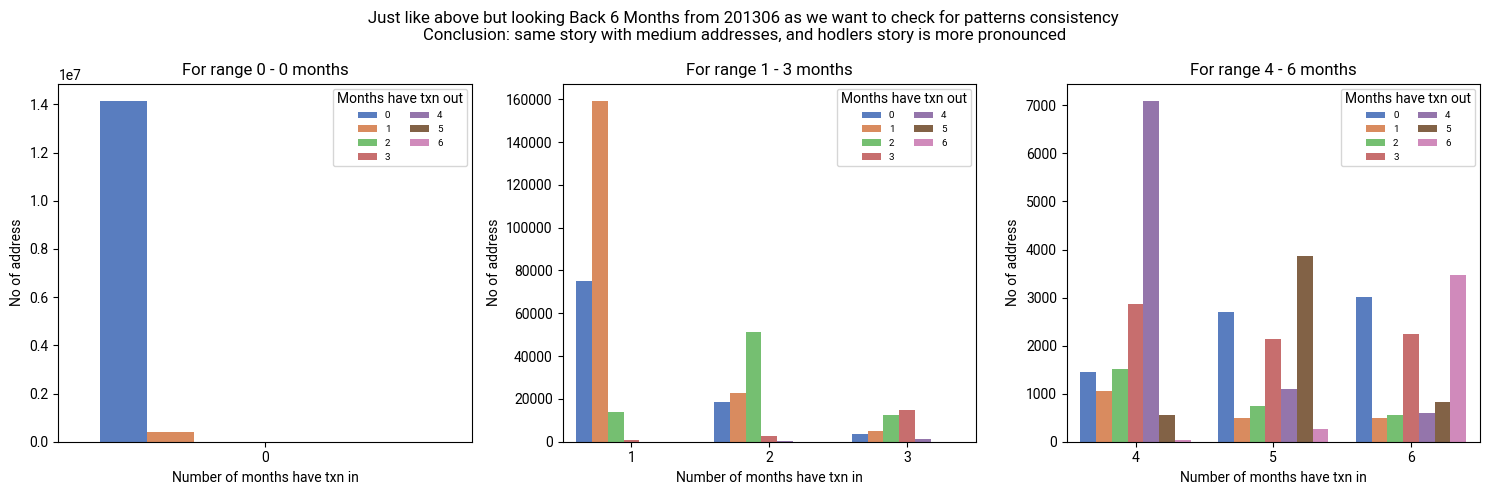

In [85]:
#df_inout_cate_2 = read_sql(query)

fig, axes = plt.subplots(1,3, figsize= (15,5))
range_txn = [[0], [1,2,3], [4,5,6]]
axes = axes.flatten()
for ax,range_txn in zip(axes,range_txn) :
    sns.barplot(x = 'count_month_in' , y = 'count_add' , hue = 'count_month_out'
                , data = df_inout_cate_2[df_inout_cate_2['count_month_in'].isin(range_txn)] 
                , ax = ax, palette = 'muted'
                )
    ax.set_title(f'For range {min(range_txn)} - {max(range_txn)} months')
    ax.set_xlabel('Number of months have txn in')
    ax.set_ylabel('No of address')
    ax.legend(
    title='Months have txn out',
    loc='upper right',
    ncol=2,  # Arrange legend items in 2 columns
    fontsize=7
    )
plt.suptitle('Just like above but looking Back 6 Months from 201306 as we want to check for patterns consistency \n'
            'Conclusion: same story with medium addresses, and hodlers story is more pronounced'
            )

plt.tight_layout()
plt.show()

### We now know a little bit about how the btc balance and btc txn is distributed, lets try to do somethings more interesting, lets try to identify btc persona by using some of the features related to:
### +btc balance avg 6m
### +amount transaction avg 6m
### +numer of transaction avg 6m
### +number of months have txn looking back 6m
### +last month have txn
### +is miner?
### +number of months the address was on chain 
### I will be using k-means with report month as of 201310. Note that this is just for fun and I am aware that a person most certainly possess more than 1 addresses which makes the analysis for single address as a single entity nonsense

In [406]:
#df_cluster = read_sql('select * from minhtp_cluster_feature_percentile_2')
print('Columns to be used:')
print(df_cluster.columns)

Columns to be used:
Index(['miner_flag', 'month_onchain', 'btc_balance_avg_6m',
       'count_outflow_avg_6m', 'count_inflow_avg_6m', 'sum_outflow_avg_6m',
       'sum_inflow_avg_6m', 'month_id', 'month_last_active',
       'count_active_month', 'month_onchain_pc', 'btc_balance_avg_6m_pc',
       'count_outflow_avg_6m_pc', 'count_inflow_avg_6m_pc',
       'sum_outflow_avg_6m_pc', 'sum_inflow_avg_6m_pc',
       'count_active_month_pc', 'month_last_active_pc', 'Cluster'],
      dtype='object')


### Now we should examine the distribution of each features. I use a boxplot and then further break them down into quartiles for better inspection 

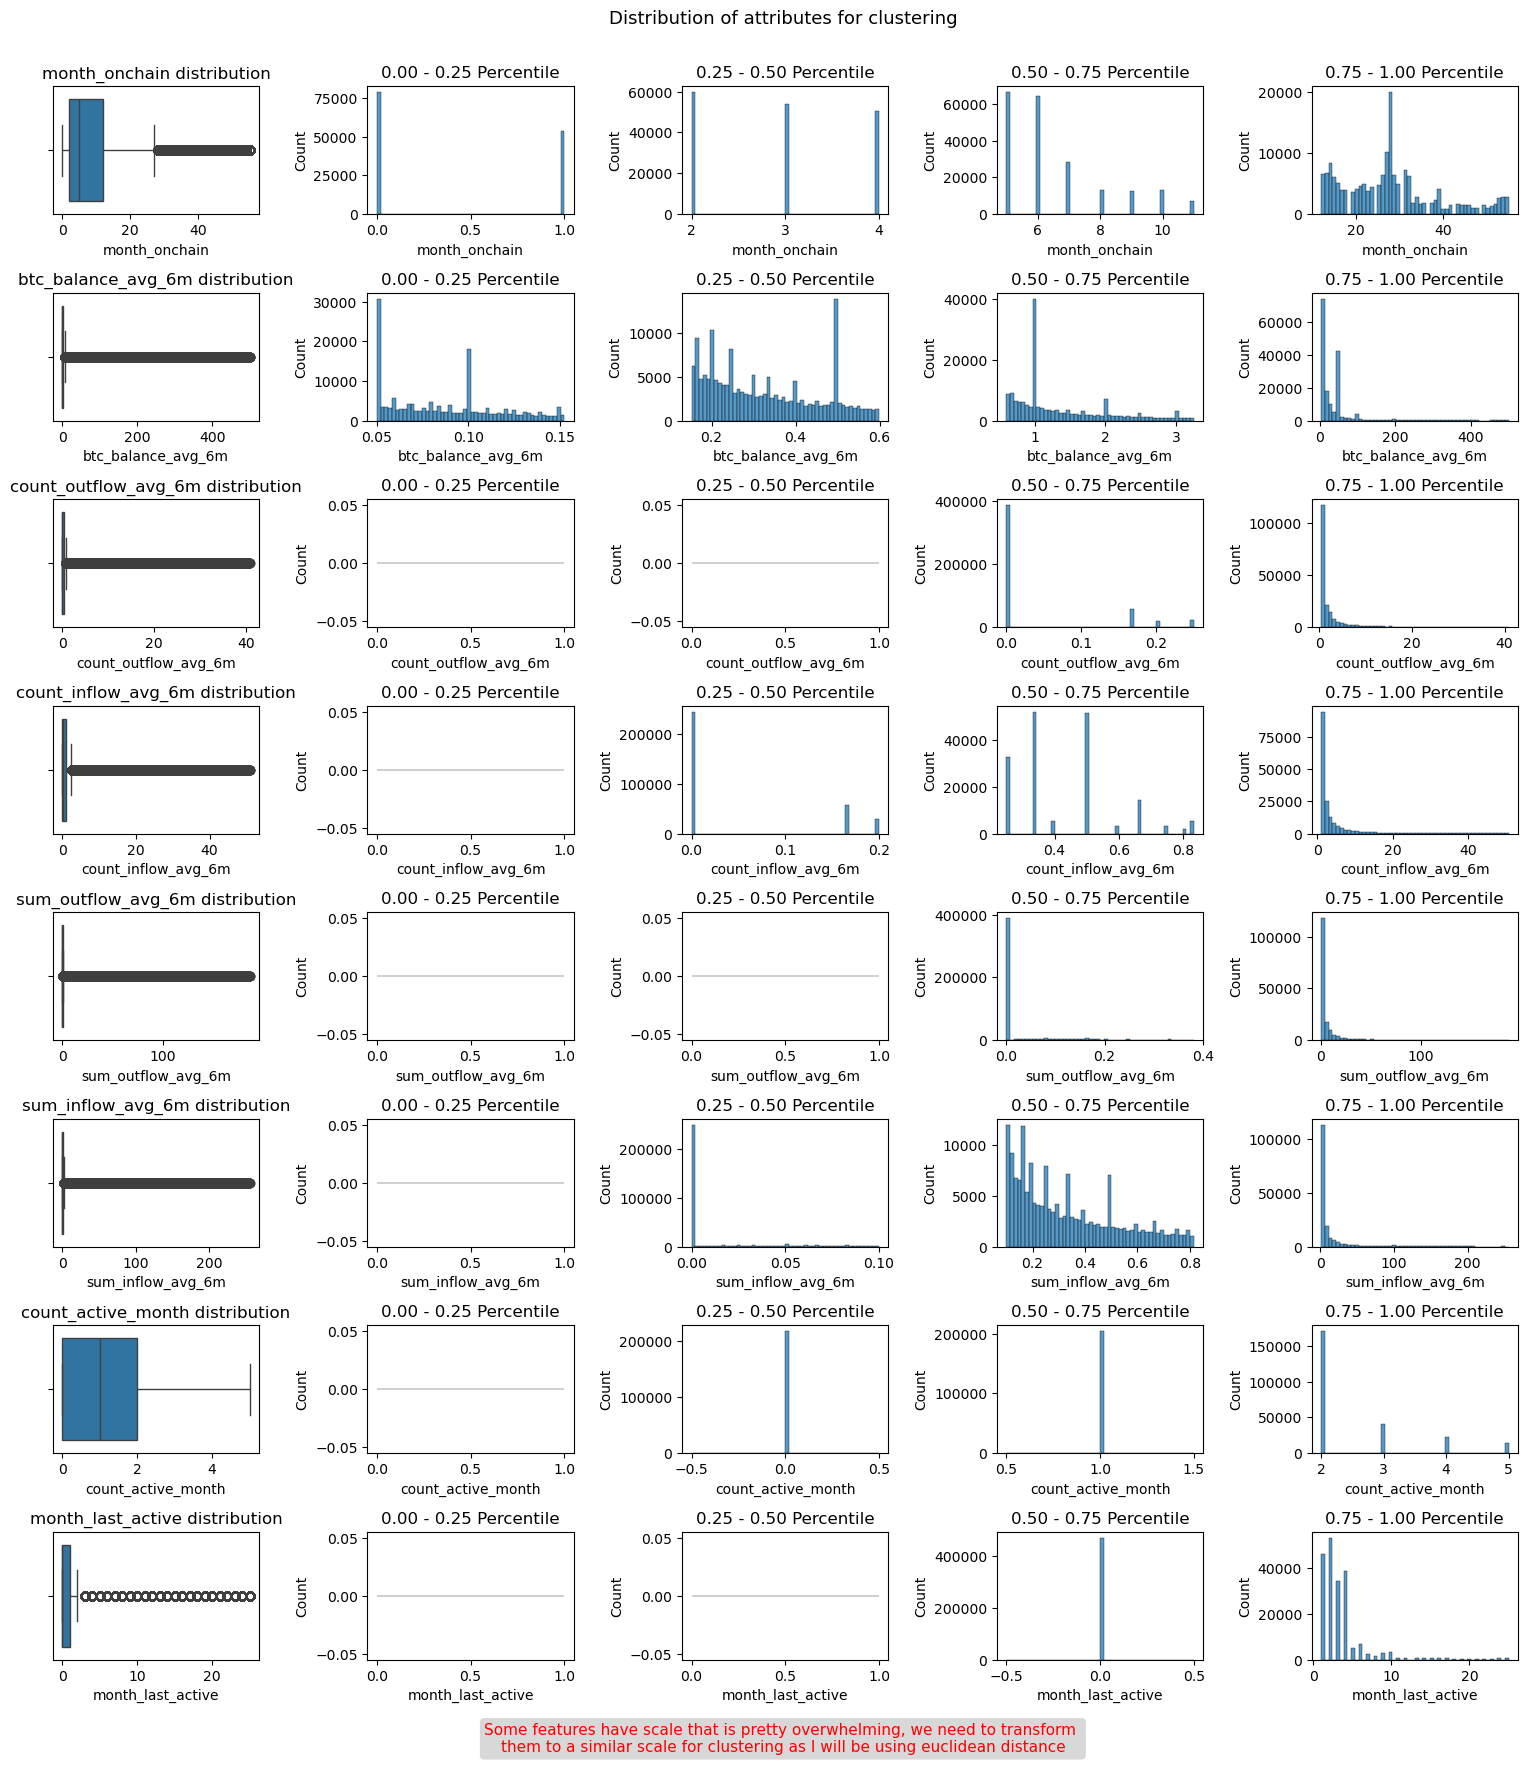

In [417]:
#df_cluster = read_sql('select * from minhtp_cluster_feature_percentile_2')

percentile_range =  [(i/100,(i+25)/100) for i in range(0,100,25)]
cols = ['month_onchain', 'btc_balance_avg_6m',
       'count_outflow_avg_6m', 'count_inflow_avg_6m', 'sum_outflow_avg_6m',
       'sum_inflow_avg_6m' , 'count_active_month', 'month_last_active' ]

fig,axes = plt.subplots(8,5, figsize = (15,17))
axes = axes.flatten()
for i,col in enumerate(cols):
        for ax, (lower,upper)  in zip(axes[5*i+1:5*i+5] , percentile_range):
            col_pc = col + '_pc'
            data_filtered = df_cluster[(df_cluster[col_pc] >= lower ) & (df_cluster[col_pc] < upper)]
            sns.histplot(data_filtered, x = col, ax =ax, bins = 50 )
            ax.set_title(f'{lower:.2f} - {upper:.2f} Percentile' )    
for i,col in enumerate(cols):
            axes[5*i].set_title(f'{col} distribution'  )    
            sns.boxplot(df_cluster[df_cluster[col + '_pc'] < 1 ] , x= col, ax = axes[5*i])
plt.suptitle('Distribution of attributes for clustering', fontsize = 13 ,y = 1.005)
plt.subplots_adjust(bottom=0.02) 
comment = ('Some features have scale that is pretty overwhelming, we need to transform \n'
            'them to a similar scale for clustering as I will be using euclidean distance')
fig.text(0.5, -0.02,comment,bbox=dict(facecolor='grey', alpha=0.3, boxstyle='round',edgecolor='none'),ha = 'center', color = 'red', fontsize = 11)
plt.tight_layout()
plt.show()


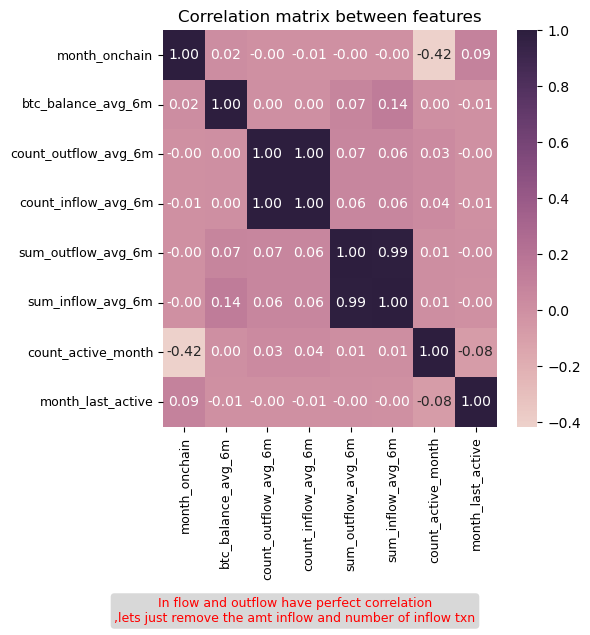

In [437]:
cor_matrix =  df_cluster[cols].corr()
plt.figure(figsize = (6,6))
sns.heatmap(cor_matrix ,annot=True, cmap=sns.cubehelix_palette(as_cmap=True), fmt=".2f" )
plt.xticks(fontsize = 9)
plt.yticks(fontsize = 9)
plt.title('Correlation matrix between features')
comment = ('In flow and outflow have perfect correlation\n'
          ',lets just remove the amt inflow and number of inflow txn')
plt.text(0.5,-0.05,comment,bbox=dict(facecolor='grey', alpha=0.3, boxstyle='round'
                                 ,edgecolor='none'),va = 'bottom'
                                , ha = 'center' , color = 'red', fontsize = 9, transform=plt.gcf().transFigure
)

plt.tight_layout()
plt.show()

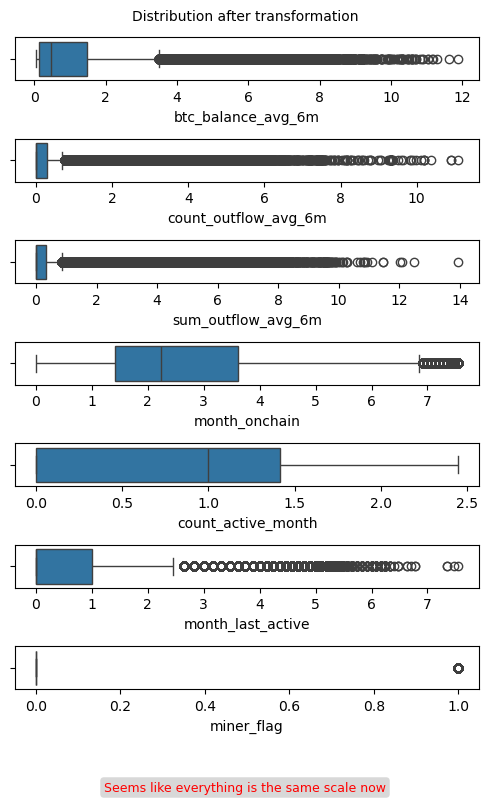

In [446]:
import numpy as np

cols_trans_log = ['btc_balance_avg_6m',
       'count_outflow_avg_6m', 'sum_outflow_avg_6m']
col_trans_sqrt = ['month_onchain','count_active_month', 'month_last_active']
col_no_trans = ['miner_flag']
# Step 1: Standardize the dataset
data_scaled = pd.concat( [np.log1p(df_cluster[cols_trans_log]), np.sqrt(df_cluster[col_trans_sqrt]), df_cluster[col_no_trans] ], axis = 1 ) 

fig, axes = plt.subplots(7,1 , figsize = (5,8))
for ax, col in zip(axes,  data_scaled.columns):
    sns.boxplot(data = data_scaled, x = col , ax =ax )
plt.suptitle('Distribution after transformation', fontsize = 10)
comment = ('Seems like everything is the same scale now')
plt.text(0.5,-0.001,comment,bbox=dict(facecolor='grey', alpha=0.3, boxstyle='round'
                                 ,edgecolor='none'),va = 'bottom'
                                , ha = 'center' , color = 'red', fontsize = 9, transform=plt.gcf().transFigure
)

plt.tight_layout()
plt.show()


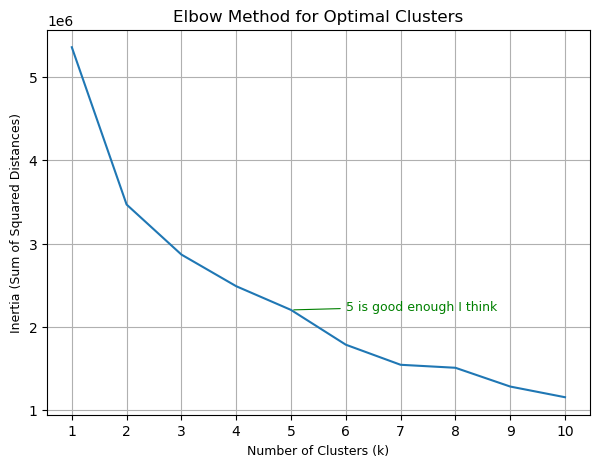

In [453]:
from sklearn.cluster import KMeans

# Step 1: Define a range of cluster numbers
inertia = []
k_range = range(1, 11)  # Test k values from 1 to 10

# Step 2: Calculate inertia for each k
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(data_scaled)
    inertia.append(kmeans.inertia_)  # Sum of squared distances

# Step 3: Plot the elbow curve
plt.figure(figsize=(7, 5))
sns.lineplot(x = k_range , y = inertia)
plt.title("Elbow Method for Optimal Clusters", fontsize=12)
plt.xlabel("Number of Clusters (k)", fontsize=9)
plt.ylabel("Inertia (Sum of Squared Distances)", fontsize=9)
plt.xticks(k_range)
plt.annotate(
    '5 is good enough I think',  # Annotation text
    xy=(5, inertia[4] ) , # Point to annotate
    xytext=(5 + 1, inertia[4]  + 5),  # Text position
    arrowprops=dict(arrowstyle='-', color='green', lw=0.8),  # Minimal arrow
    fontsize=9,
    color='green'
)
plt.grid(True)
plt.show()


In [456]:
kmeans = KMeans(n_clusters=5, random_state=42)
kmeans.fit(data_scaled)
clusters = kmeans.labels_

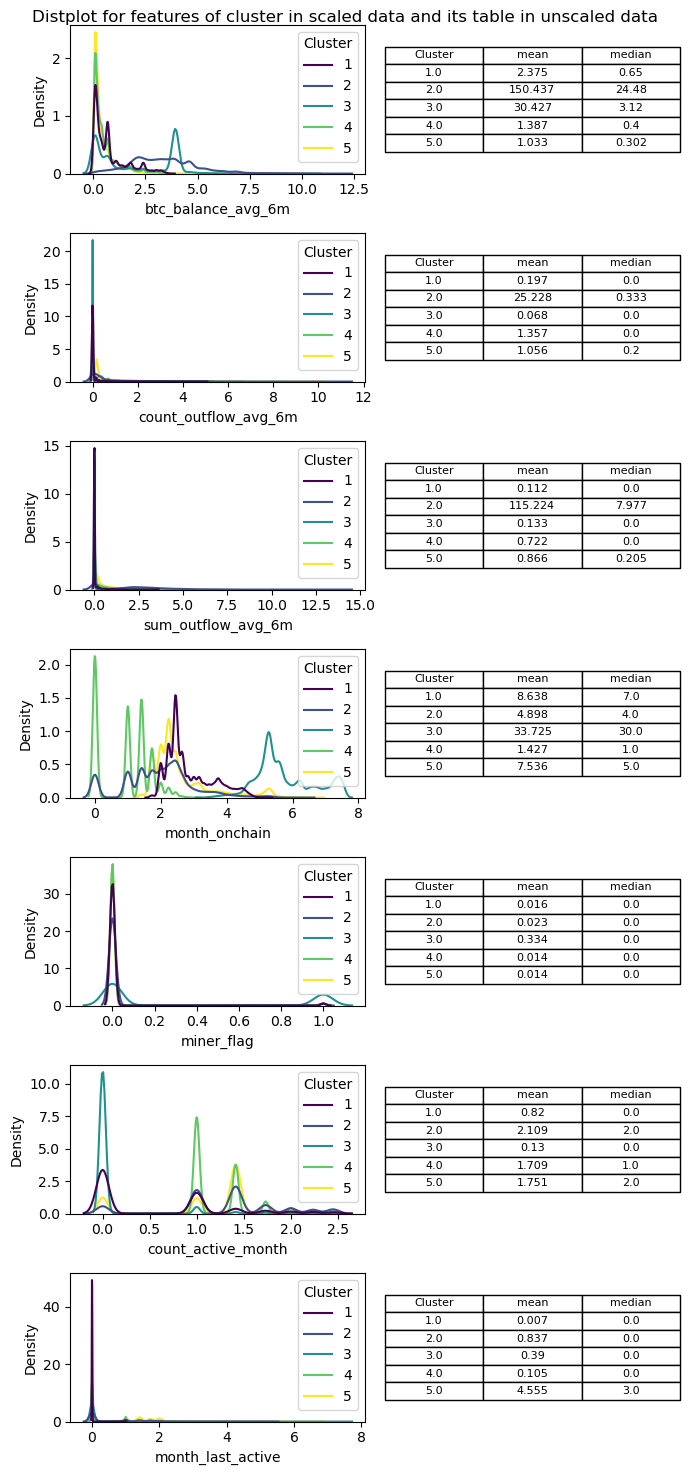

In [459]:
df_cluster['Cluster'] = clusters + 1
data_scaled['Cluster'] = clusters + 1
col_check = [ 'btc_balance_avg_6m', 'count_outflow_avg_6m',
            'sum_outflow_avg_6m', 'month_onchain',
       'miner_flag', 'count_active_month', 'month_last_active' ]

fig, axes = plt.subplots(7,2, figsize = (7,15))
axes = axes.flatten()
for i,col in enumerate(col_check):
    sns.kdeplot(data = data_scaled, x = col, hue = 'Cluster', ax = axes[i*2], common_norm = False, palette="viridis")
#    axes[i*2].legend(fontsize = 'small', loc = 'upper right')
    df_cluster_gb =  df_cluster[[col ,'Cluster']].groupby('Cluster').agg(['mean', 'median'])
    df_cluster_gb = df_cluster_gb.round(3)
    df_cluster_gb.columns = ['_'.join(col).strip() for col in df_cluster_gb.columns]
    df_cluster_gb = df_cluster_gb.reset_index()
    axes[i * 2 + 1].axis('off')  # Hide axes and gridlines for a clean table
    table = axes[i * 2 + 1].table(
        cellText=df_cluster_gb.values,
        colLabels=['Cluster' ,'mean', 'median'],
        cellLoc="center",
        loc="center"
    )
    # Optional: You can further tweak the table appearance here (e.g., remove borders)
    table.auto_set_font_size(False)
    table.set_fontsize(8)  # Set font size if needed
    table.scale(1, 1)  # Scale the table to fit better
plt.suptitle('Distplot for features of cluster in scaled data and its table in unscaled data')    
plt.tight_layout()
plt.show()


## Lets do radar chart to better visualization of cluster persona, features are ranked from 1-5 within 5 cluster to be plotted on radar chart

In [460]:
col_check = [ 'btc_balance_avg_6m', 'count_outflow_avg_6m',
            'sum_outflow_avg_6m', 'month_onchain',
       'miner_flag', 'count_active_month', 'month_last_active' ]
col_check_cluster = col_check + ['Cluster']
df_cluster_gb =  df_cluster[col_check_cluster].groupby('Cluster').agg(['mean'])
df_cluster_gb.columns = ['_'.join(col).strip() for col in df_cluster_gb.columns]

In [461]:
for col in df_cluster_gb.columns :
    df_cluster_gb[col+'_rank'] = df_cluster_gb[col].rank()


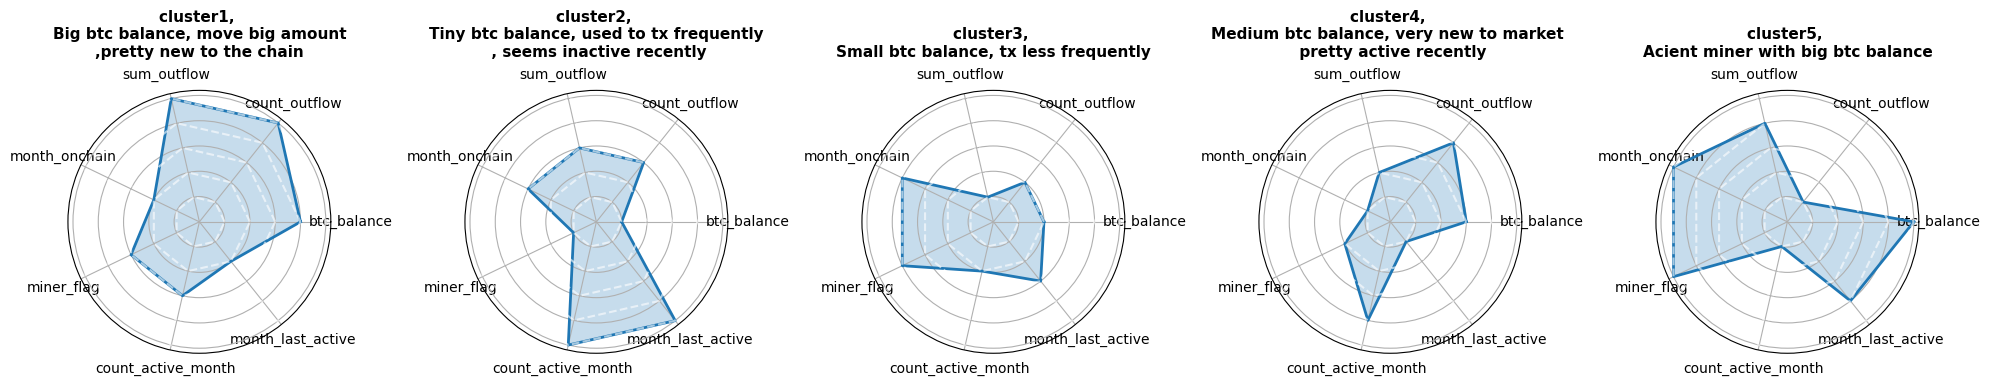

In [405]:

data = df_cluster_gb.iloc[:,7:14]

data.columns = ['btc_balance', 'count_outflow',
       'sum_outflow', 'month_onchain',
       'miner_flag', 'count_active_month',
       'month_last_active']

# Example data for 5 clusters
categories = data.columns

# Example values for each cluster

# Create subplots for 5 clusters
fig, axes = plt.subplots(1, 5, figsize=(20, 5), subplot_kw=dict(polar=True))

# Define function to draw a radar chart
def draw_radar(ax, data, categories,num_circles):
    # Number of variables (features)
    num_vars = len(categories)

    # Compute angle for each category (feature)
    angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()

    # Make the radar chart circular by closing the loop
    data = np.concatenate((data, [data.iloc[0]]))  # Append first value at the end
    angles += angles[:1]  # Close the loop for the chart

    # Plot the data on the radar chart
    ax.plot(angles, data, linewidth=2, linestyle='solid', label="Cluster")
    ax.fill(angles, data, alpha=0.25)
    for i in range(1, num_circles + 1):
        circle_values = [i] * num_vars  # Set the circle value to 'i' for each angle
        circle_values += [circle_values[0]]  # Close the loop for the circle
        ax.plot(angles, circle_values, linestyle='--', color='white', alpha=0.6)

    # Set the labels and ticks
    ax.set_yticklabels([])  # Hide radial ticks
    ax.set_xticks(angles[:-1])  # Set category angles
    ax.set_xticklabels(categories)
    
cluster_name = [('Big btc balance, move big amount\n'',pretty new to the chain'),
               ('Tiny btc balance, used to tx frequently\n '', seems inactive recently'), 
               'Small btc balance, tx less frequently',
               ('Medium btc balance, very new to market \n'' pretty active recently'),
                'Acient miner with big btc balance'
               ]
# Loop through each cluster and draw its radar chart
for i in range(5):
    ax = axes[i]  # Get the corresponding axis for the current cluster
    draw_radar(ax, data.iloc[i,:], categories , num_circles = 5 )
    ax.set_title(f'cluster{i+1}, \n{cluster_name[i]}' , fontsize=11, weight='bold',va = 'bottom')
# Adjust the layout for the plots
plt.tight_layout()
plt.show()

